# Modelowanie układów przepływowych
### Sylwester Arabas, Agnieszka Żaba, Mirosław Zimnoch
### ćwiczenia 2 (5/6.XI.2025): rozszerzenie kodu UPWIND 2D (wykł. 3) do MPDATA 2D

# Materiał z wykładu:

In [1]:
from collections.abc import Callable, Sequence
from typing import Any, Type

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors, pyplot
from numpy import dtype, float64, int64, ndarray
from open_atmos_jupyter_utils import show_anim

#### 0. umożliwienie operacji typu `i+one`, `i-half` dla `i` typu `slice`:

In [2]:
class Shift:
    def __init__(self, plus: int, minus: int) -> None:
        self.plus: int = plus
        self.minus: int = minus

    def __radd__(self, arg: slice) -> slice:
        return slice(arg.start + self.plus, arg.stop + self.plus)

    def __rsub__(self, arg: slice) -> slice:
        return slice(arg.start - self.minus, arg.stop - self.minus)

one = Shift(1, 1)
half = Shift(0, 1)

#### 1. logika rozszerzania zakresu `slice` (np. `extend(slice(0,1), half)`)

In [3]:
def extend(r: slice, n: int | Shift) -> slice:
    if isinstance(n, int) and n == 1:
        n = Shift(1, 1)
    if isinstance(n, int):
        start = r.start - n
        stop = r.stop + n
    else:
        start = r.start - n.minus
        stop = r.stop + n.plus
    return slice(start, stop, r.step)

#### 2. permutacje indeksów, schemat numeryczny UPWIND

In [4]:
def pi(d: int, *arg: slice) -> tuple[slice, slice]:
    return arg[d], arg[d - 1]


def f(
    psi_l: ndarray[tuple[int, ...], dtype[float64]],
    psi_r: ndarray[tuple[int, ...], dtype[float64]],
    C: ndarray[tuple[int, ...], dtype[float64]],
) -> ndarray[tuple[int, ...], dtype[float64]]:
    return ((C + abs(C)) * psi_l + (C - abs(C)) * psi_r) / 2


def upwind(
    d: int,
    psi: ndarray[tuple[int, ...], dtype[float64]],
    C: ndarray[tuple[int, ...], dtype[float64]],
    i: slice,
    j: slice,
) -> ndarray[tuple[int, ...], dtype[float64]]:
    return f(
        psi[pi(d, i, j)],
        psi[pi(d, i + one, j)],
        C[pi(d, i + half, j)],
    ) - f(
        psi[pi(d, i - one, j)],
        psi[pi(d, i, j)],
        C[pi(d, i - half, j)],
    )

#### 3. klasa reprezentująca solwer (pole skalarne `advectee` unoszone przez przepływ `advector`)

In [30]:
class Upwind:

    def __init__(
        self,
        grid: Sequence[int],
        bc: Sequence[Callable[[int, slice, int], Any]],
        halo: int = 1,
    ) -> None:
        assert len(grid) == (supported_n_dims := 2)
        self.n = 0
        self.dims = range(supported_n_dims)
        self.ij = tuple(slice(halo, grid[d] + halo) for d in self.dims)
        self.bc = tuple(bc[d](d, self.ij[d], halo) for d in self.dims)
        self.psi = tuple(
            np.empty(
                tuple(extend(self.ij[d], halo).stop for d in self.dims), dtype=float64
            )
            for n in range(2)
        )
        self.advector: tuple[ndarray[tuple[int, ...], dtype[float64]], ...] = tuple(
            np.empty(
                tuple(
                    extend(self.ij[q], half if d == q else halo).stop for q in self.dims
                )
            )
            for d in self.dims
        )
        self.halo = halo

    @property
    def advectee(self) -> ndarray[tuple[int, ...], dtype[float64]]:
        return self.psi[self.n][self.ij]

    def fill_bc(self) -> None:
        for d in self.dims:
            self.bc[d](self.psi[self.n], extend(self.ij[d - 1], self.halo))

    def step(self) -> None:
        self.fill_bc()
        self.psi[self.n + 1][self.ij] = self.psi[self.n][self.ij]
        for d in self.dims:
            self.psi[self.n + 1][self.ij] -= upwind(
                d, self.psi[self.n], self.advector[d], *pi(d, *self.ij)
            )
        self.n = (self.n + 1) % 2 - 2

#### 4. cykliczny (periodyczny) warunek brzegowy




In [6]:
class Cyclic:
    def __init__(
        self,
        d: int,
        i: slice,
        halo: int,
    ) -> None:
        self.d = d
        self.left_halo = slice(i.start - halo, i.start)
        self.right_edge = slice(i.stop - halo, i.stop)
        self.right_halo = slice(i.stop, i.stop + halo)
        self.left_edge = slice(i.start, i.start + halo)

    def __call__(
        self,
        psi: ndarray[tuple[int, ...], dtype[float64]],
        j: slice,
    ) -> None:
        psi[pi(self.d, self.left_halo, j)] = psi[pi(self.d, self.right_edge, j)]
        psi[pi(self.d, self.right_halo, j)] = psi[pi(self.d, self.left_edge, j)]

#### 5. instancja solwera, określenie warunku początkowego i pola prędkości

In [31]:
solver: Upwind = Upwind(grid := (32, 16), bc=(Cyclic, Cyclic))

x = np.linspace(-10, 10, grid[0])
y = np.linspace(-10, 10, grid[1])
x0, y0 = 0.0, 0.0
sigma = 2.0


def set_initial_condition(solver: Upwind) -> None:
    solver.advectee[:] = np.exp(
        -((x[:, None] - x0) ** 2 + (y[None, :] - y0) ** 2) / (2 * sigma**2)
    )


def set_courant_numbers(solver: Upwind) -> None:
    solver.advector[0][:] = 0.5
    solver.advector[1][:] = 0.25

#### 6. całkowanie w czasie

In [8]:
set_initial_condition(solver)
set_courant_numbers(solver)

history: list[ndarray[tuple[int, ...], dtype[float64]]] = []
for n in range((nt := 100) + 1):
    if n != 0:
        solver.step()
    history.append(solver.advectee.copy())

#### 7. wizualizacja

In [18]:
def plot(n, history: list, zlim=(0, 1)):
    axs = (fig := pyplot.figure(figsize=(8, 8))).add_subplot(projection="3d")
    axs.set(xlabel="x", zlim=zlim, title=f"t / dt = {n}", ylabel="y", zlabel="psi")
    fig.colorbar(
        axs.plot_surface(
            *np.meshgrid(y, x),
            history[n],
            color="k",
            cmap=plt.colormaps["coolwarm"],
            norm=colors.Normalize(*zlim),
        ),
        fraction=0.03,
        location="bottom",
    )
    return fig


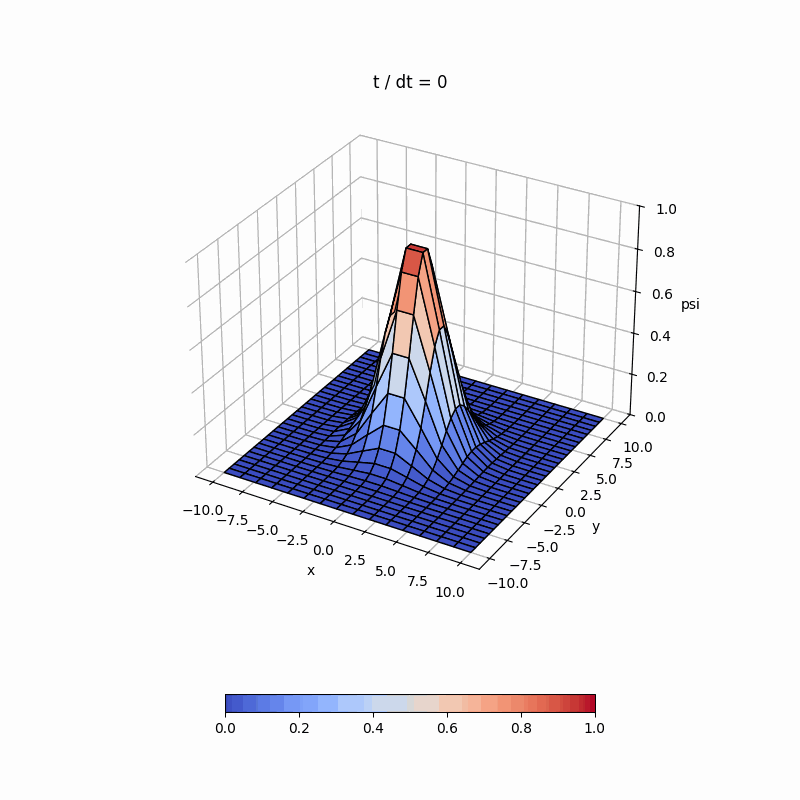

HTML(value="<a href='.\\lab2_anim.gif' target='_blank'>.\\lab2_anim.gif</a><br>")

In [ ]:
show_anim(lambda x: plot(x, history), range(len(history)), gif_file="anim_with_numeric_diffusion.gif")

# Materiał na ćwiczenia:

#### 8. oszacowanie dyfuzji numerycznej (współczynnik $k$) wyrażone jako "antydyfuzyjna" liczba Couranta $\vec{D}=(D^{[x]}, D^{[y:]})$:

$$
\partial_t\psi + \partial_x \big(\!\!\!\!\!\!\!\!\!\!\!\!\underbrace{k \frac{\partial_x \psi}{\psi}}_\text{prędkość antydyfuzyjna} \!\!\!\!\!\!\!\!\!\!\!\!\psi\big) = 0
$$

$$
D^\text{[x]}_{i+\frac{1}{2},j }
= \frac{\Delta t}{\Delta x} k_{i+\frac{1}{2},j} \left.\frac{\partial_x \psi}{\psi}\right|_{i+\frac{1}{2},j}
\!\!\approx \left(|C^{[x]}_{i+\frac{1}{2},j}|-(C^{[x]}_{i+\frac{1}{2},j})\right)^2\underbrace{\frac{\psi_{i+1,j}-\psi_{i,j}}{\psi_{i+1,j}+\psi_{i,j}+\epsilon}}_{A_{i,j}} 

- C^{[x]}_{i+\frac{1}{2},j} \underbrace{\frac{1}{2}\frac{\psi_{i+1,j+1}+\psi_{i,j+1}-\psi_{i+1,j-1}-\psi_{i,j-1}}{\psi_{i+1,j+1}+\psi_{i,j+1}+\psi_{i+1,j-1}+\psi_{i,j-1}+\epsilon}}_{B_{i,j}}\overbrace{\frac{C^{[y]}_{i+1,j+\frac{1}{2}}+C^{[y]}_{i,j+\frac{1}{2}}+C^{[y]}_{i+1,j-\frac{1}{2}}+C^{[y]}_{i,j-\frac{1}{2}}}{4}}^{\bar{C}_{i,j}}
$$

In [55]:
epsilon = 1e-5


def A(d: int, i: slice, j: slice, psi: np.ndarray):
    return (psi[pi(d, i + one, j)] - psi[pi(d, i, j)]) / (
        psi[pi(d, i + one, j)] + psi[pi(d, i, j)] + epsilon
    )


def B(d: int, i: slice, j: slice, psi: np.ndarray):
    return (
        0.5
        * (
            psi[pi(d, i + one, j + one)]
            + psi[pi(d, i, j + one)]
            - psi[pi(d, i + one, j - one)]
            - psi[pi(d, i, j - one)]
        )
        / (
            psi[pi(d, i + one, j + one)]
            + psi[pi(d, i, j + one)]
            + psi[pi(d, i + one, j - one)]
            + psi[pi(d, i, j - one)]
        )
    )


def C_bar(d: int, i: slice, j: slice, C: np.ndarray):
    return 0.25 * (
        C[pi(d, i + one, j + half)]
        + C[pi(d, i, j + half)]
        + C[pi(d, i + one, j - half)]
        + C[pi(d, i, j - half)]
    )


def D(d: int, i: slice, j: slice, psi: np.ndarray, Cs: Sequence[np.ndarray]):
    return (abs(Cs[d][pi(d, i + half, j)]) - Cs[d][pi(d, i + half, j)] ** 2) * A(
        d, i, j, psi
    ) - Cs[d][pi(d, i + half, j)] * C_bar(d, i, j, Cs[d - 1]) * B(d, i, j, psi)

In [56]:
# def D(
#     dim: int,
#     i: slice,
#     j: slice,
#     psi: ndarray[tuple[int, ...], dtype[float64]],
#     C: Sequence[ndarray[tuple[int, ...], dtype[float64]]],
#     *,
#     eps: float = 1e-10,
# ) -> ndarray[tuple[int, ...], dtype[float64]]:
#     """
#     Antydyfuzyjna liczba Courant
#     """
#     C_abs = np.abs(C[dim][pi(dim, i + half, j)])
#     C2 = C[dim][pi(dim, i + half, j)] ** 2

#     psi_add_one_i_j = psi[pi(dim, i + one, j)]
#     psi_i_j = psi[pi(dim, i, j)]
#     A_ij = (psi_add_one_i_j - psi_i_j) / (psi_add_one_i_j + psi_i_j + eps)

#     return (C_abs - C2) * A_ij

9. całkowanie w czasie z krokiem korekcyjnym "odcałkowującym" dyfuzję numeryczną

In [57]:
set_initial_condition(solver)
history = []
for n in range(nt + 1):
    if n != 0:
        # krok UPWIND z "fizycznymi" liczbami Courant'a
        set_courant_numbers(solver)
        solver.step()

        # krok korekcyjny UPWIND z "antydyfuzyjnymi" liczbami Courant'a
        # solver.fill_bc()
        for d in solver.dims:

            im = extend(solver.ij[d], half) + half
            j = solver.ij[d - 1]
            solver.advector[d][pi(d, im + half, j)] = D(
                d,
                im,
                j,
                solver.psi[solver.n],
                solver.advector,
            )
            # solver.bc[d - 1](solver.advector[d], extend(solver.ij[d - 1], solver.halo))
        solver.step()
    history.append(solver.advectee.copy())


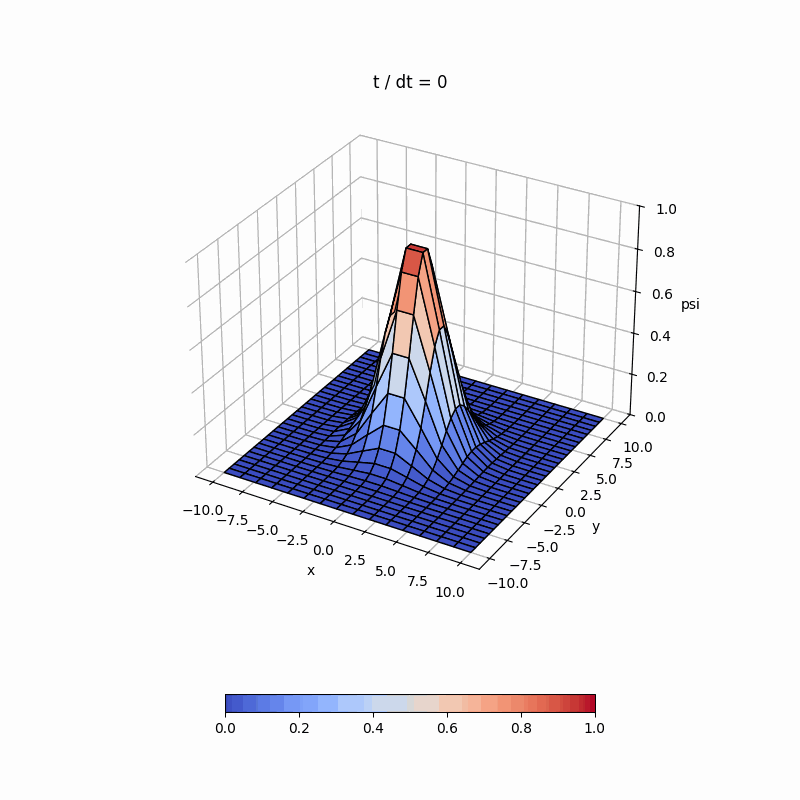

HTML(value="<a href='.\\tmp1qowfb18.gif' target='_blank'>.\\tmp1qowfb18.gif</a><br>")

In [ ]:
show_anim(lambda x: plot(x, history), range(len(history)),gif_file="amin_numeric_diffusion_cancellation.gif")